 We decided to use LDA language model to analysis the data that we mined from reddit. Before starting the analysis, we need to decide how many topics that we need to analyze. in this case, the coherence score can provide us with a certain level of reference. The code is from: https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-3-ab03e01b7cd7 

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [8]:
df = pd.read_csv('/Users/sakice/Library/Mobile Documents/com~apple~CloudDocs/Documents/DP/reddit_data (1).csv', encoding='utf-8')
df

,type,title,author,score,url,created,num_comments,subreddit,content
0,post,Rednote the chinese version of tik tok is #2 i...,GuitarIsLife02,1041,https://i.redd.it/0ss2ep5hkpce1.jpeg,2025-01-13 06:50:26+00:00,429.0,TheDeprogram,The people once again showing how based they c...
1,comment,Rednote the chinese version of tik tok is #2 i...,AutoModerator,1,https://i.redd.it/0ss2ep5hkpce1.jpeg,2025-01-13 06:50:28+00:00,NaN,TheDeprogram,☭☭☭ [SUBSCRIBE TO THE BOIS ON YOUTUBE](https:/...
2,comment,Rednote the chinese version of tik tok is #2 i...,KazVanilla,322,https://i.redd.it/0ss2ep5hkpce1.jpeg,2025-01-13 06:53:37+00:00,NaN,TheDeprogram,I thought xiaohongshu was the Chinese version ...
3,comment,Rednote the chinese version of tik tok is #2 i...,stalbox,128,https://i.redd.it/0ss2ep5hkpce1.jpeg,2025-01-13 08:07:56+00:00,NaN,TheDeprogram,TikTok/Douyin is the Chinese version of TikTok
4,comment,Rednote the chinese version of tik tok is #2 i...,soweli_tonsi,197,https://i.redd.it/0ss2ep5hkpce1.jpeg,2025-01-13 08:01:10+00:00,NaN,TheDeprogram,goddam this is a bleak snapshot into the very ...
...,...,...,...,...,...,...,...,...,...
21411,comment,CIA headquarters rn after Rednote just deprogr...,ToKeNgT,36,https://i.redd.it/v1rmi8cvv3de1.gif,2025-01-15 11:59:54+00:00,NaN,TheDeprogram,https://preview.redd.it/s5iwj0gid5de1.jpeg?wid...
21412,comment,CIA headquarters rn after Rednote just deprogr...,nukefall_,10,https://i.redd.it/v1rmi8cvv3de1.gif,2025-01-15 13:36:19+00:00,NaN,TheDeprogram,METATITLEEE
21413,comment,CIA headquarters rn after Rednote just deprogr...,boopbopnotarobot,6,https://i.redd.it/v1rmi8cvv3de1.gif,2025-01-15 14:49:21+00:00,NaN,TheDeprogram,Roll credits!
21414,comment,CIA headquarters rn after Rednote just deprogr...,CarpenterCheaper,8,https://i.redd.it/v1rmi8cvv3de1.gif,2025-01-15 15:48:20+00:00,NaN,TheDeprogram,live lightiggy reaction:\n\nhttps://i.redd.it/...


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sakice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

In [9]:
data = list(df.content.astype(str))

In [10]:
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [12]:
data_ready = process_words(data)

In [13]:
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 16190


In [14]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [18]:
mallet_path = '/Users/sakice/Downloads/mallet-2.0.8/bin/mallet'

In [19]:
# display a progress meter
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1, cpus=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=topic_nums,
                                                            id2word=dictionary, iterations=500, workers=cpus)
      
    cv_coherence_model_mallet_lda = gensim. models.CoherenceModel (model=mallet_lda_model, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
      
    coherence_score = cv_coherence_model_mallet_lda.get_coherence()
    coherence_scores.append(coherence_score)
    models.append(mallet_lda_model)
  return models, coherence_scores  
                                       

In [20]:
import multiprocessing
cpus = multiprocessing.cpu_count()  # Use all available CPUs
lda_models, coherence_scores = topic_model_coherence_generator(
    corpus=corpus, texts=data_ready, dictionary=id2word, start_topic_count=2, end_topic_count=50, step=2, cpus=cpus
)

  0%|          | 0/25 [00:00<?, ?it/s]Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 643
total tokens: 293491
<10> LL/token: -8.43177
<20> LL/token: -8.33896
<30> LL/token: -8.25822
<40> LL/token: -8.19471

0	25	people government make thing country good chinese app tiktok medium work american propaganda bad social year give time call ban 
1	25	chinese tiktok ban app datum government post user social company medium rednote reddit comment content make people platform https foreign 

<50> LL/token: -8.14137
<60> LL/token: -8.09417
<70> LL/token: -8.05255
<80> LL/token: -8.02458
<90> LL/token: -7.99971

0	25	people government make thing country good work bad time propaganda lot year point talk give care call learn chinese state 
1	25	tiktok chinese app ban social medium datum rednote government post user company content platform reddit comment american video control foreign 

<100> LL/token: -7.98069
<110> LL/token: -7.96804
<120> LL/token: -7.95425
<130> LL/toke

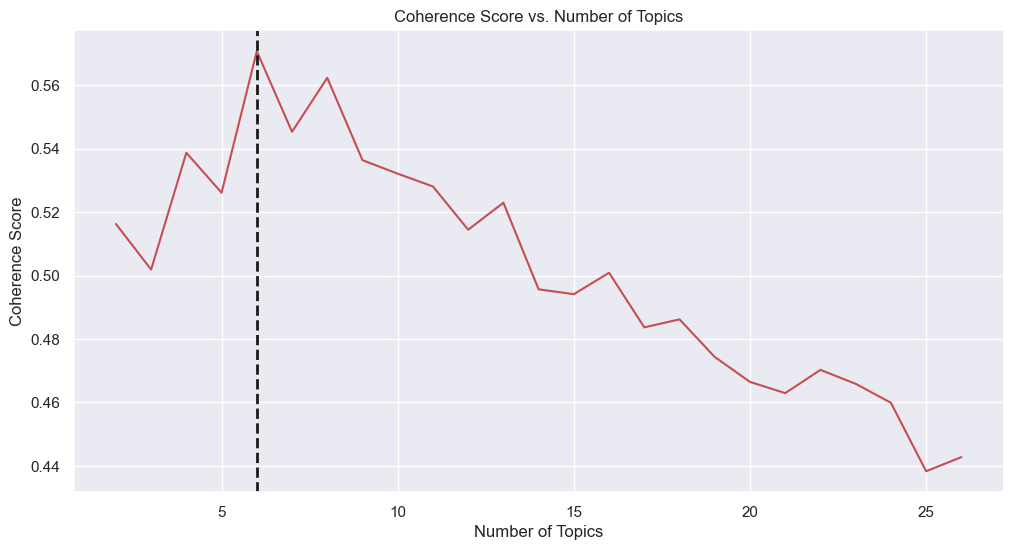

In [28]:
x_ax = range(2, 2 + len(coherence_scores))  # Adjust x_ax to match y_ax length
y_ax = coherence_scores

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axvline(x=6, c='k', linestyle='dashed', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.show()

As we can see, the result of coherence score is the highes while the number of topics is six. in this case, we chose 6 topics to analyze the comments through lda model.